## Automated anisotropic resistivity inversion for efficient formation evaluation and uncertainty quantification

### Misael M. Morales, Oriyomi Raheem, Ali Eghbali, Michael Pyrcz, Carlos Torres-Verdin
***

In [ ]:
from main import *
ari = ARI()
case1, case2 = ari.load_data()

### Case 1

In [ ]:
case1_qinv = ari.quadratic_inversion(case1)

In [ ]:
inv1 = ari.resistivity_inversion(case1, x0=[0.5,1.45], Rvsh=2.813, Rhsh=0.775, 
                                 Wd_matrix=True, tolerance=1e-10, maxiter=1e5, 
                                 lambda_reg=1e-8, method='CG', bounds=None)

ari.plot_inversion_results(inv1, figsize=(20,12))

In [ ]:
inv1 = ari.resistivity_inversion(case1, x0=[0.5, 1.45], Rvsh=2.813, Rhsh=0.775,
                                 Wd_matrix=True, tolerance=1e-10, maxiter=1e5,
                                 lambda_reg=1e-8, method='L-BFGS-B', bounds=[(0,1),(None,None)])

ari.plot_inversion_results(inv1, figsize=(20,12))

### Case 2

In [ ]:
case2_qinv = ari.quadratic_inversion(case2)

In [ ]:
inv2 = ari.resistivity_inversion(case2, x0=[0.5,1.45], Rvsh=4.043, Rhsh=0.674,
                                 Wd_matrix=True, tolerance=1e-10, maxiter=1e5, 
                                 lambda_reg=1e-8, method='CG', bounds=None)

ari.plot_inversion_results(inv2, figsize=(20,12))

In [ ]:
inv2 = ari.resistivity_inversion(case2, x0=[0.5,1.45], Rvsh=4.043, Rhsh=0.674, 
                                 Wd_matrix=True, tolerance=1e-8, maxiter=1e5, 
                                 lambda_reg=1e-8, method='L-BFGS-B', bounds=[(0,1),(None,None)])

ari.plot_inversion_results(inv2, figsize=(20,12))

***
# Physics-Informed Artificial Neural Network
***

In [1]:
from main import *
ari = ARI()
case1, case2 = ari.load_data()


------------------------------------------------------------
----------------------- VERSION INFO -----------------------
Torch version: 2.2.2+cu121 | Torch Built with CUDA? True
# Device(s) available: 1, Name(s): NVIDIA GeForce RTX 3080
------------------------------------------------------------



In [371]:
def plot_pinn_results(results, figsize=(12.5,12.5), height_ratios=[1, 0.3, 0.3],
                      gr_lim=[0,150], at_lim=[0.2,50], r_lim=[0.15,120], h_lim=[0.2,10],
                      csh_c='k', rss_c='k', bins=50, cmaps=['Reds','Blues']):

    fig = plt.figure(figsize=figsize)
    gs = GridSpec(3, 4, figure=fig, height_ratios=height_ratios)

    ax11 = fig.add_subplot(gs[0, 0]); ax11.set(ylabel='Depth [ft]')
    ax12 = fig.add_subplot(gs[0, 1])
    ax13 = fig.add_subplot(gs[0, 2])
    ax14 = fig.add_subplot(gs[0, 3])

    ax21 = fig.add_subplot(gs[1, 0])
    ax22 = fig.add_subplot(gs[1, 1])
    ax23 = fig.add_subplot(gs[1, 2])
    ax24 = fig.add_subplot(gs[1, 3])

    ax3 = fig.add_subplot(gs[2,:])

    ax11b = ax11.twiny()
    ari.plot_curve(ax11, results, 'GR', gr_lim[0], gr_lim[1], 'g', units='API', pad=8)
    ari.plot_curve(ax11b, results, 'Csh_pred', 0, 1, csh_c, units='v/v')

    ax12b, ax12c = ax12.twiny(), ax12.twiny()
    ari.plot_curve(ax12, results, 'AT10', at_lim[0], at_lim[1], 'r', semilog=True, units='$\Omega\cdot m$', pad=8)
    ari.plot_curve(ax12b, results, 'AT90', at_lim[0], at_lim[1], 'b', semilog=True, units='$\Omega\cdot m$', pad=16)
    ari.plot_curve(ax12c, results, 'Rss_pred', at_lim[0], at_lim[1], rss_c, units='$\Omega\cdot m$', semilog=True)

    ax13b, ax13c = ax13.twiny(), ax13.twiny()
    ari.plot_curve(ax13, results, 'Rv', at_lim[0], at_lim[1], 'r', semilog=True, units='$\Omega\cdot m$', pad=8)
    ari.plot_curve(ax13b, results, 'Rv_sim', at_lim[0], at_lim[1], 'k', units='$\Omega\cdot m$', semilog=True)
    ari.plot_curve(ax13c, results, 'Rv_err', 0, 100, 'darkred', alpha=0.5, units='%', pad=16)

    ax14b, ax14c = ax14.twiny(), ax14.twiny()
    ari.plot_curve(ax14, results, 'Rh', at_lim[0], at_lim[1], 'b', semilog=True, units='$\Omega\cdot m$', pad=8)
    ari.plot_curve(ax14b, results, 'Rh_sim', at_lim[0], at_lim[1], 'k', units='$\Omega\cdot m$', semilog=True)
    ari.plot_curve(ax14c, results, 'Rh_err', 0, 100, 'darkblue', alpha=0.5, units='%', pad=16)

    [ax.grid(True, which='both') for ax in [ax11, ax12, ax13, ax14]]
    [ax.invert_yaxis() for ax in [ax11, ax12, ax13, ax14]]

    ax21.hist(results['Csh_pred'], bins=bins, color=csh_c, edgecolor='k', alpha=0.6, density=True)
    ax21.set(xlabel='Csh', ylabel='Density', xlim=(0,1))

    ax22.hist(results['Rss_pred'], bins=bins, color=rss_c, edgecolor='k', alpha=0.6, density=True)
    ax22.set(xlabel='Rss [$\Omega\cdot m$]', ylabel='Density')

    ax23.scatter(results['Rv'], results['Rv_sim'], c=results.index, cmap=cmaps[0], edgecolor='gray', alpha=0.6)
    ax23.set(xlabel='Rv true [$\Omega\cdot m$]', ylabel='Rv simulated [$\Omega\cdot m$]',
                xlim=r_lim, ylim=r_lim, xscale='log', yscale='log')
    ax23.plot(r_lim, r_lim, 'k--')

    ax24.scatter(results['Rh'], results['Rh_sim'], c=results.index, cmap=cmaps[1], edgecolor='gray', alpha=0.6)
    ax24.set(xlabel='Rh true [$\Omega\cdot m$]', ylabel='Rh simulated [$\Omega\cdot m$]',
                xlim=h_lim, ylim=h_lim, xscale='log', yscale='log')
    ax24.plot(h_lim, h_lim, 'k--')

    [ax.grid(True, which='both', alpha=0.4) for ax in [ax21, ax22, ax23, ax24, ax3]]

    ax3.plot(results.index, results['Rvsh'], c='darkred', label='Rvsh')
    ax3.plot(results.index, np.ones_like(results['Rvsh'])*results['Rvsh'].mean(), c='r', ls='--', label='Rvsh_mean')
    ax3.text(10025, results['Rvsh'].mean()+2, 'Mean: {:.3f}'.format(results['Rvsh'].mean()), color='r', bbox=dict(facecolor='lightgrey'))
    ax3.plot(results.index, results['Rhsh'], c='darkblue', label='Rhsh')
    ax3.plot(results.index, np.ones_like(results['Rhsh'])*results['Rhsh'].mean(), c='b', ls='--', label='Rhsh_mean')
    ax3.text(10025, results['Rhsh'].mean()+.5, 'Mean: {:.3f}'.format(results['Rhsh'].mean()), color='b', bbox=dict(facecolor='lightgrey'))
    ax3.legend(facecolor='lightgrey', edgecolor='k')
    ax3.set(yscale='log', xlabel='Depth [ft]', ylabel='Resistivity [$\Omega\cdot m$]')

    plt.tight_layout()
    plt.show()
    return None

In [375]:
def plot_pinn_gb_comparison(pinn_results, gb_results, figsize=(12.5,12.5), height_ratios=[1, 0.3],
                            gr_lim=[0,150], at_lim=[0.2,50], pinn_c='k', gb_c='gray', cmaps=['Greens', 'Oranges', 'Reds','Blues']):

    fig = plt.figure(figsize=figsize)
    gs = GridSpec(2, 4, figure=fig, height_ratios=height_ratios)

    ax11 = fig.add_subplot(gs[0, 0]); ax11.set(ylabel='Depth [ft]')
    ax12 = fig.add_subplot(gs[0, 1])
    ax13 = fig.add_subplot(gs[0, 2])
    ax14 = fig.add_subplot(gs[0, 3])

    ax21 = fig.add_subplot(gs[1, 0]); ax21.set(xlim=(0,1), ylim=(0,1), ylabel='Gradient-Based')
    ax22 = fig.add_subplot(gs[1, 1]); ax22.set(xlim=(0.2,80), ylim=(0.2,80))
    ax23 = fig.add_subplot(gs[1, 2])
    ax24 = fig.add_subplot(gs[1, 3])

    axs = [ax11, ax12, ax13, ax14, ax21, ax22, ax23, ax24]

    ax11b, ax11c = ax11.twiny(), ax11.twiny()
    ari.plot_curve(ax11, pinn_results, 'GR', gr_lim[0], gr_lim[1], 'g', units='API')
    ari.plot_curve(ax11b, gb_results, 'Csh_pred', 0, 1, gb_c, ls='--', units='v/v', pad=8)
    ari.plot_curve(ax11c, pinn_results, 'Csh_pred', 0, 1, pinn_c, ls='--', units='v/v', pad=16)

    ax12b, ax12c, ax12d = ax12.twiny(), ax12.twiny(), ax12.twiny()
    ari.plot_curve(ax12, pinn_results, 'AT10', at_lim[0], at_lim[1], 'r', semilog=True, units='$\Omega\cdot m$')
    ari.plot_curve(ax12b, pinn_results, 'AT90', at_lim[0], at_lim[1], 'b', semilog=True, units='$\Omega\cdot m$', pad=8)
    ari.plot_curve(ax12c, gb_results, 'Rss_pred', at_lim[0], at_lim[1], gb_c, semilog=True, units='$\Omega\cdot m$', pad=16)
    ari.plot_curve(ax12d, pinn_results, 'Rss_pred', at_lim[0], at_lim[1], pinn_c, semilog=True, units='$\Omega\cdot m$', pad=24)

    ax13b, ax13c = ax13.twiny(), ax13.twiny()
    ari.plot_curve(ax13, pinn_results, 'Rv', at_lim[0], at_lim[1], 'r', semilog=True, units='$\Omega\cdot m$')
    ari.plot_curve(ax13b, gb_results, 'Rv_sim', at_lim[0], at_lim[1], gb_c, ls='--', semilog=True, units='$\Omega\cdot m$', pad=8)
    ari.plot_curve(ax13c, pinn_results, 'Rv_sim', at_lim[0], at_lim[1], pinn_c, ls='--', semilog=True, units='$\Omega\cdot m$', pad=16)

    ax14b, ax14c = ax14.twiny(), ax14.twiny()
    ari.plot_curve(ax14, pinn_results, 'Rh', at_lim[0], at_lim[1], 'b', semilog=True, units='$\Omega\cdot m$')
    ari.plot_curve(ax14b, gb_results, 'Rh_sim', at_lim[0], at_lim[1], gb_c, ls='--', semilog=True, units='$\Omega\cdot m$', pad=8)
    ari.plot_curve(ax14c, pinn_results, 'Rh_sim', at_lim[0], at_lim[1], pinn_c, ls='--', semilog=True, units='$\Omega\cdot m$', pad=16)

    ax21.scatter(pinn_results['Csh_pred'], gb_results['Csh_pred'], c=pinn_results.index, cmap=cmaps[0], edgecolor='gray', alpha=0.6)
    ax22.scatter(pinn_results['Rss_pred'], gb_results['Rss_pred'], c=pinn_results.index, cmap=cmaps[1], edgecolor='gray', alpha=0.6)
    ax23.scatter(pinn_results['Rv_sim'], gb_results['Rv_sim'], c=pinn_results.index, cmap=cmaps[2], edgecolor='gray', alpha=0.6)
    ax24.scatter(pinn_results['Rh_sim'], gb_results['Rh_sim'], c=pinn_results.index, cmap=cmaps[3], edgecolor='gray', alpha=0.6)

    [ax.set(xscale='log') for ax in [ax12, ax13]]
    [ax.invert_yaxis() for ax in [ax11, ax12, ax13]]
    [ax.grid(True, which='both', alpha=0.4) for ax in axs]
    [ax.set(xlabel='PINN') for ax in axs[3:]]
    [ax.set(xscale='log', yscale='log') for ax in axs[-3:]]
    [ax.axline((0,0), (1,1), c='k', ls='--') for ax in axs[-3:]]

    plt.tight_layout()
    plt.show()
    return None

***
underdetermined inversion
$$ m = g(d) $$
$$ [C_{sh}, R_{ss}, R_v^{sh}, R_h^{sh}] = g (R_v, R_h) $$

In [268]:
class ResInvPINN(nn.Module):
    def __init__(self):
        super(ResInvPINN, self).__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 4)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        c, s, v, h = x[:, 0], x[:, 1], x[:, 2], x[:, 3]
        #c, s = x[:, 0], x[:, 1]
        c = nn.Sigmoid()(c)
        v = nn.ELU()(v)
        h = nn.ELU()(h)
        x = torch.stack([c, s, v, h], dim=-1)
        #x = torch.stack([c, s], dim=-1)
        return x        
    
class ResInvLoss(nn.Module):
    def __init__(self, lambda_reg=1e-5):
        super(ResInvLoss, self).__init__()
        self.lambda_reg = lambda_reg

    def forward(self, inputs, outputs):
        Rv_true = inputs[:, 0]
        Rh_true = inputs[:, 1]

        Csh_pred = outputs[:, 0]
        Rss_pred = outputs[:, 1]

        Rvsh_pred = outputs[:, 2]
        Rhsh_pred = outputs[:, 3]

        eq1 = (Csh_pred*Rvsh_pred + (1-Csh_pred)*Rss_pred) - (Rv_true)
        eq2 = 1/(Csh_pred/Rhsh_pred + (1-Csh_pred)/Rss_pred) - (Rh_true)
        eqs = torch.stack([eq1, eq2], dim=-1)

        wd1, wd2 = 1/Rv_true, 1/Rh_true
        Wdm = torch.stack([wd1, wd2], dim=-1)

        costf = torch.norm(torch.matmul(Wdm.T, eqs), p=2)
        regPa = self.lambda_reg*torch.norm(outputs[:,[2,3]], p=2)

        return  costf + regPa

In [269]:
d = lasio.read('well1.las').df()[['CALI', 'AT10','AT30','AT60','AT90','GR','RV72H_1D_FLT','RH72H_1D_FLT']].dropna()
column_names = ['CALI', 'AT10', 'AT30', 'AT60', 'AT90', 'GR', 'Rv', 'Rh']

zstart = int(np.argwhere(d.index==9720).squeeze())
zend   = int(np.argwhere(d.index==10110).squeeze())
data = d.rename(columns=dict(zip(d.columns, column_names))).iloc[zstart:zend]

res_aniso  = data[['Rv', 'Rh']]

inputs = torch.tensor(res_aniso.values, dtype=torch.float32)
print('Inputs: {}'.format(inputs.shape))

Inputs: torch.Size([1560, 2])


X_train: 1326 | X_valid: 234
Epoch: 0 | Loss: 158.9616 | Valid Loss: 116.5943
Epoch: 100 | Loss: 6.9725 | Valid Loss: 6.0787
Epoch: 200 | Loss: 3.3295 | Valid Loss: 3.8812
Epoch: 300 | Loss: 2.0274 | Valid Loss: 1.3585


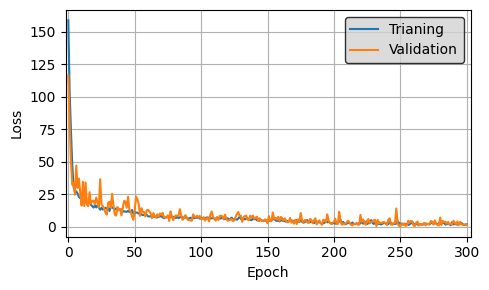

In [352]:
dataset        = TensorDataset(inputs)
train_percent  = 0.85
xtrain, xvalid = random_split(dataset, [int(train_percent*len(dataset)), len(dataset)-int(train_percent*len(dataset))])
print('X_train: {} | X_valid: {}'.format(len(xtrain), len(xvalid)))

trainloader    = DataLoader(xtrain, batch_size=50, shuffle=True)
validloader    = DataLoader(xvalid, batch_size=50, shuffle=True)

pinn       = ResInvPINN()
criterion  = ResInvLoss(lambda_reg=1e-4)
optimizer  = torch.optim.Adam(pinn.parameters(), lr=1e-3)

epochs, monitor = 301, 100
train_loss, valid_loss = [], []
for epoch in range(epochs):
    # training
    epoch_train_loss = []
    pinn.train()
    for batch in trainloader:
        optimizer.zero_grad()
        x = batch[0]
        y = pinn(x)
        loss = criterion(x, y)
        loss.backward()
        optimizer.step()
        epoch_train_loss.append(loss.item())
    train_loss.append(np.mean(epoch_train_loss))
    # validation
    pinn.eval()
    epoch_valid_loss = []
    with torch.no_grad():
        x = next(iter(validloader))[0]
        y = pinn(x)
        loss = criterion(x, y)
        epoch_valid_loss.append(loss.item())
    valid_loss.append(np.mean(epoch_valid_loss))
    # progress
    if epoch % monitor == 0:
        print('Epoch: {} | Loss: {:.4f} | Valid Loss: {:.4f}'.format(epoch, train_loss[-1], valid_loss[-1]))

plt.figure(figsize=(5,3))
plt.plot(range(epochs), train_loss, label='Trianing', c='tab:blue')
plt.plot(range(epochs), valid_loss, label='Validation', c='tab:orange')
plt.legend(facecolor='lightgrey', edgecolor='k')
plt.grid(True, which='both')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.xlim(-2, epochs+2)
plt.tight_layout()
plt.show()

Csh: min=0.395 | max=0.413


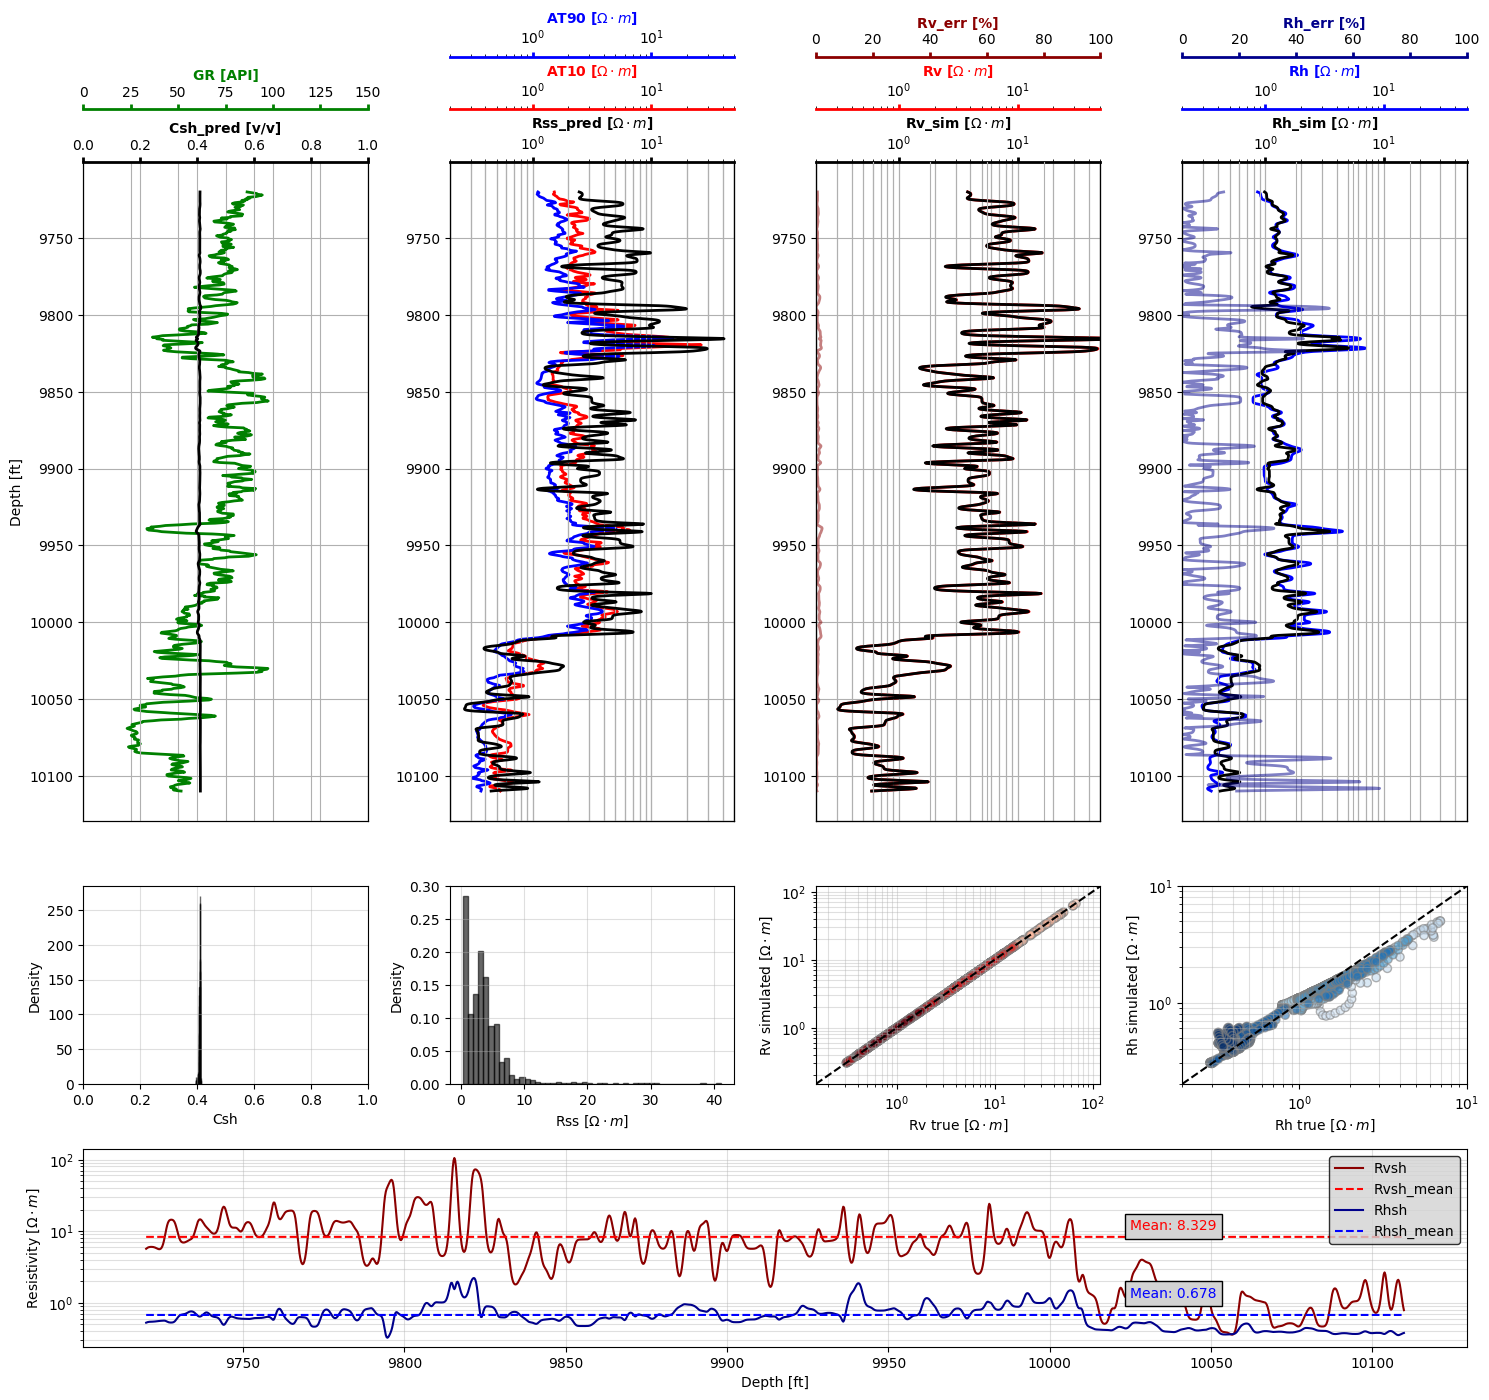

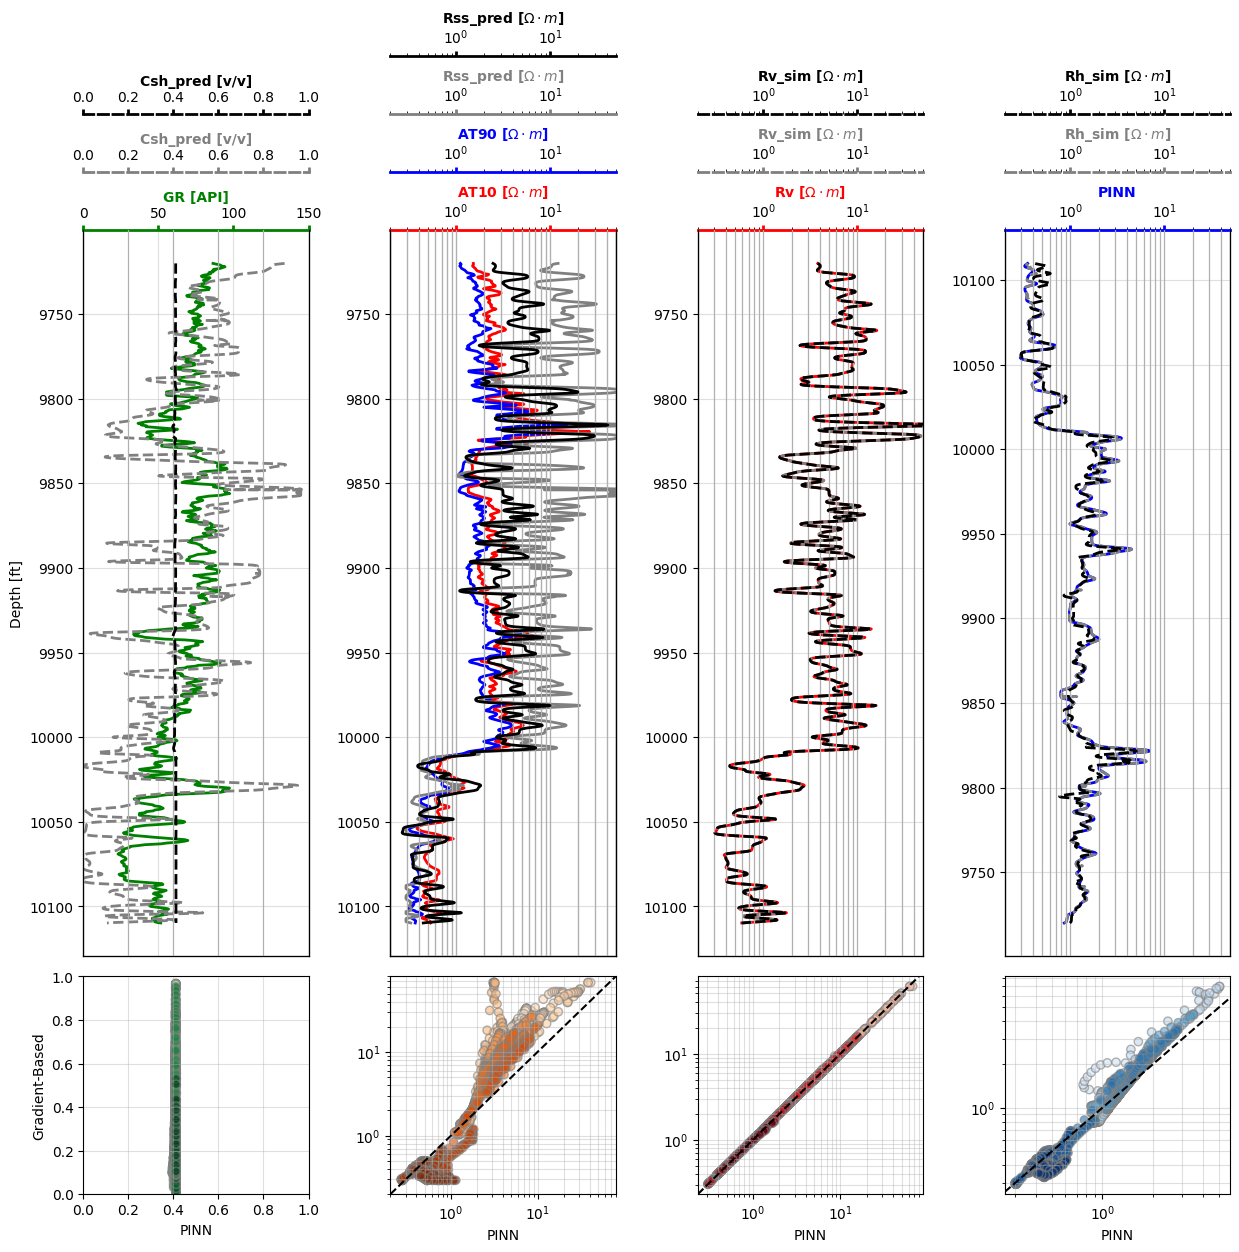

In [374]:
y_pred = pinn(inputs[:,:2]).detach().numpy().squeeze()
Csh_pred, Rss_pred, Rvsh_pred, Rhsh_pred = [y_pred[:, i] for i in range(y_pred.shape[1])]
#Csh_pred, Rss_pred = [y_pred[:, i] for i in range(y_pred.shape[1])]
#Rvsh_pred, Rhsh_pred = res_aniso['Rvsh'].values, res_aniso['Rhsh'].values
print('Csh: min={:.3f} | max={:.3f}'.format(Csh_pred.min(), Csh_pred.max()))

Rv_true = res_aniso['Rv'].values
Rh_true = res_aniso['Rh'].values

Rv_sim = (Csh_pred*Rvsh_pred + (1-Csh_pred)*Rss_pred)
Rh_sim = 1/(Csh_pred/Rhsh_pred + (1-Csh_pred)/Rss_pred)

Rv_err = np.abs((Rv_sim - Rv_true)/Rv_true) * 100
Rh_err = np.abs((Rh_sim - Rh_true)/Rh_true) * 100

pinn_sol = pd.DataFrame({'Csh_pred':Csh_pred, 'Rss_pred':Rss_pred, 
                         'Rvsh':Rvsh_pred, 'Rhsh':Rhsh_pred,
                         'Rv_sim':Rv_sim, 'Rh_sim':Rh_sim,
                         'Rv_err':Rv_err, 'Rh_err':Rh_err}, index=res_aniso.index)

results = pd.concat([data, pinn_sol], axis=1)

plot_pinn_results(results, figsize=(15,14))
plot_pinn_gb_comparison(results, sol)

***
# END
***

In [ ]:
def plot_inversion_solution(data, sol, ali, figsize=(16.5,10)):
    fig, axs = plt.subplots(1,5, figsize=figsize, sharey=True, width_ratios=[0.6,0.6,0.6,1,1])
    ax1, ax2, ax3, ax4, ax5 = axs
    colors = ['darkviolet','royalblue','firebrick']
    ax1.plot(data['GR'], data.index, c='g', label='GR')
    ax1.grid(True, which='both')
    ax1.set(xlim=(20,120), title='GR')
    ax1.hlines(10188.75, 0, data['GR'].max(), color='k', lw=5)
    ax2.plot(data['Rv'], data.index, c='k', label='Rv')
    ax2.plot(ali['Rv_sim'], ali['df'].iloc[1:2156,0], c='b', ls='--', label='Ali_sim')
    ax2.plot(sol['Rv_sim'], sol.index, c='r', ls='--', label='Simulated')
    ax2.set(xscale='log', title='Rv')
    ax2.grid(True, which='both')
    ax2.legend(loc='upper left', facecolor='lightgrey', edgecolor='k')
    ax2.hlines(10188.75, 0, sol['Rss_pred'].max(), color='k', lw=5)
    ax3.plot(data['Rh'], data.index, c='k', label='Rh')
    ax3.plot(ali['Rh_sim'], ali['df'].iloc[1:2156,0], c='b', ls='--', label='Ali_sim')
    ax3.plot(sol['Rh_sim'], sol.index, c='r', ls='--', label='Simulated')
    ax3.set(xscale='log', title='Rh')
    ax3.grid(True, which='both')
    ax3.legend(loc='upper left', facecolor='lightgrey', edgecolor='k')
    ax3.hlines(10188.75, 0, sol['Rss_pred'].max(), color='k', lw=5)
    ax4.plot(ali['Csh'], ali['df'].iloc[1:2156,0], label='Ali_1', c='b')
    ax4.plot(ali['df'].iloc[:,14], ali['df'].iloc[:,0], label='Ali_2')
    ax4.plot(sol['Csh_pred'], sol.index, label='Mine', ls='--', c='r')
    ax4.set(title='Csh', xlim=(0,1))
    ax4.legend(loc='upper left', facecolor='lightgrey', edgecolor='k')
    ax4.grid(True, which='both')
    ax4.hlines(10188.75, 0, 1, color='k', lw=5)
    ax5.plot(ali['Rss'], ali['df'].iloc[1:2156,0], label='Ali_1', c='b')
    ax5.plot(ali['df'].iloc[:,15], ali['df'].iloc[:,0], label='Ali_2')
    ax5.plot(sol['Rss_pred'], sol.index, label='Mine', ls='--', c='r')
    ax5.set(xscale='log', title='Rss'); 
    ax5.legend(loc='upper left', facecolor='lightgrey', edgecolor='k')
    ax5.grid(True, which='both')
    ax5.hlines(10188.75, 0, sol['Rss_pred'].max(), color='k', lw=5)
    ax1.invert_yaxis()
    plt.tight_layout()
    plt.show()

def plot_inversion_comparison(sol, ali, figsize=(15,10)):
    fig, axs = plt.subplots(1, 6, figsize=figsize, sharey=True)
    ax1, ax2, ax3, ax4, ax5, ax6 = axs
    ax1.plot(sol['Rv'], sol.index, c='k', lw=2.75, label='Rv_true')
    ax1.plot(sol['Rv_sim'], sol.index, c='r', ls='--', label='Rv_sim')
    ax1.set(title='Rv_sim'); ax1.grid(True, which='both'); ax1.set_xscale('log')
    ax1.legend(facecolor='lightgrey', edgecolor='k', loc='upper right')
    ax2.plot(sol['Rh'], sol.index, c='k', lw=2.75, label='Rh_true')
    ax2.plot(sol['Rh_sim'], sol.index, c='r', ls='--', label='Rh_sim')
    ax2.set(title='Rh_sim'); ax2.grid(True, which='both'); ax2.set_xscale('log')
    ax2.legend(facecolor='lightgrey', edgecolor='k', loc='upper right')
    ax3.plot(sol['Rv'], sol.index, c='k', lw=2.75, label='Rv_true')
    ax3.plot(ali['Rv_sim'], ali['df'].iloc[:2155,0], c='b', ls='--', label='ALI_Rv_sim')
    ax3.set(title='Rv_sim'); ax3.grid(True, which='both'); ax3.set_xscale('log')
    ax3.legend(facecolor='lightgrey', edgecolor='k', loc='upper right')
    ax4.plot(sol['Rh'], sol.index, c='k', lw=2.75, label='Rh_true')
    ax4.plot(ali['Rh_sim'], ali['df'].iloc[:2155,0], c='b', ls='--', label='ALI_Rh_sim')
    ax4.set(title='Rh_sim'); ax4.grid(True, which='both'); ax4.set_xscale('log')
    ax4.legend(facecolor='lightgrey', edgecolor='k', loc='upper right')
    ax5.plot(sol['Rv'], sol.index, c='k', lw=2.75, label='Rv_true')
    ax5.plot(ali['Rv_sim'], ali['df'].iloc[:2155,0], c='b', ls='--', label='ALI_Rv_sim')
    ax5.plot(sol['Rv_sim'], sol.index, c='r', ls='--', label='Rv_sim')
    ax5.set(title='Rv_sim'); ax5.grid(True, which='both'); ax5.set_xscale('log')
    ax5.legend(facecolor='lightgrey', edgecolor='k', loc='upper right')
    ax6.plot(sol['Rh'], sol.index, c='k', lw=2.75, label='Rh_true')
    ax6.plot(ali['Rh_sim'], ali['df'].iloc[:2155,0], c='b', ls='--', label='ALI_Rh_sim')
    ax6.plot(sol['Rh_sim'], sol.index, c='r', ls='--', label='Rh_sim')
    ax6.set(title='Rh_sim'); ax6.grid(True, which='both'); ax6.set_xscale('log')
    ax6.legend(facecolor='lightgrey', edgecolor='k', loc='upper right')
    for ax in axs:
        ax.hlines(10188.75, 0, sol['Rss_pred'].max(), color='k', lw=3.5)
    ax1.invert_yaxis()
    plt.tight_layout()
    plt.show()

def plot_inversion_fullsuite(data, sol, ali_sol, figsize=(17.5,10)):
    df = lasio.read('well1.las').df()
    fig, axs = plt.subplots(1, 10, figsize=(17.5,10), sharey=True)
    ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9 = axs
    ax01, ax02 = ax0.twiny(), ax0.twiny()
    ari.plot_curve(ax0, df, 'CALI', 12, 24, 'dodgerblue', units='in', fill=True, semilog=True, pad=0)
    ari.plot_curve(ax01, df, 'GR', 10, 150, 'g', units='API', pad=8)
    ari.plot_curve(ax02, sol, 'Csh_pred', 0, 1, 'r', units='v/v', s=1, pad=16)
    ax11, ax12 = ax1.twiny(), ax1.twiny()
    ari.plot_curve(ax1, data, 'Csh_lin', 0, 1, 'k', units='v/v', pad=0)
    ari.plot_curve(ax11, data, 'Csh_q', 0, 1, 'gray', units='v/v', pad=8)
    ari.plot_curve(ax12, sol, 'Csh_pred', 0, 1, 'r', units='v/v', pad=16)
    ax21, ax22 = ax2.twiny(), ax2.twiny()
    ari.plot_curve(ax2, df, 'TNPH', 1, 0, 'b', units='PU', pad=0)
    ari.plot_curve(ax21, df, 'RHOZ', 1.65, 2.65, 'maroon', units='g/cc', pad=8)
    ari.plot_curve(ax22, df, 'PE', -5, 5, 'm', units='b/e', pad=16)
    ax31, ax32 = ax3.twiny(), ax3.twiny()
    ari.plot_curve(ax3, df, 'AT10', 0.2, 100, 'darkred', semilog=True, units='$\Omega\cdot m$', pad=0)
    ari.plot_curve(ax31, df, 'AT90', 0.2, 100, 'darkblue', semilog=True, units='$\Omega\cdot m$', pad=8)
    ari.plot_curve(ax32, sol, 'Rss_pred', 0.2, 100, 'r', semilog=True, units='$\Omega\cdot m$', pad=16)
    ax41 = ax4.twiny()
    ari.plot_curve(ax4, ali_sol, 'Csh_ALI', 0, 1, 'b', units='v/v', pad=0)
    ari.plot_curve(ax41, sol, 'Csh_pred', 0, 1, 'r', ls='--', units='v/v', pad=8)
    ax51 = ax5.twiny()
    ari.plot_curve(ax5, ali_sol, 'Rss_ALI', 0.2, 100, 'b', semilog=True, units='$\Omega\cdot m$', pad=0)
    ari.plot_curve(ax51, sol, 'Rss_pred', 0.2, 100, 'r', ls='--', semilog=True, units='$\Omega\cdot m$', pad=8)
    ax61, ax62 = ax6.twiny(), ax6.twiny()
    ari.plot_curve(ax6, df, 'RV72H_1D_FLT', 0.2, 100, 'k', s=4, semilog=True, units='$\Omega\cdot m$', pad=0)
    ari.plot_curve(ax61, ali_sol, 'Rv_sim_ALI', 0.2, 100, 'b', semilog=True, units='$\Omega\cdot m$', pad=8)
    ari.plot_curve(ax62, sol, 'Rv_sim', 0.2, 100, 'r', ls='--', semilog=True, units='$\Omega\cdot m$', pad=16)
    ax71, ax72 = ax7.twiny(), ax7.twiny()
    ari.plot_curve(ax7, df, 'RH72H_1D_FLT', 0.2, 100, 'k', s=4, semilog=True, units='$\Omega\cdot m$', pad=0)
    ari.plot_curve(ax71, ali_sol, 'Rh_sim_ALI', 0.2, 100, 'b', semilog=True, units='$\Omega\cdot m$', pad=8)
    ari.plot_curve(ax72, sol, 'Rh_sim', 0.2, 100, 'r', ls='--', semilog=True, units='$\Omega\cdot m$', pad=16)
    ax81, ax82, ax83 = ax8.twiny(), ax8.twiny(), ax8.twiny()
    ari.plot_curve(ax8, data, 'Rv', 0.2, 100, 'k', s=4, semilog=True, units='$\Omega\cdot m$', pad=0)
    ari.plot_curve(ax81, sol, 'Rv_sim', 0.2, 100, 'darkred', ls='--', semilog=True, units='$\Omega\cdot m$', pad=8)
    ari.plot_curve(ax82, data, 'Rh', 0.2, 100, 'k', s=4, semilog=True, units='$\Omega\cdot m$', pad=16)
    ari.plot_curve(ax83, sol, 'Rh_sim', 0.2, 100, 'darkblue', ls='--', semilog=True, units='$\Omega\cdot m$', pad=24)
    ax91, ax92 = ax9.twiny(), ax9.twiny()
    ari.plot_curve(ax9, sol, 'fun', 1e-6, 1e0, 'k', s=1, semilog=True, units='/', pad=0)
    ari.plot_curve(ax91, sol, 'jac_norm', 0, 2.5, 'darkmagenta', s=1, units='/', pad=8, alpha=0.5)
    ari.plot_curve(ax92, sol, 'nfev', 10, 150, 'darkgreen', s=1, units='/', pad=16, alpha=0.5)
    ax1.set_ylim(10190, 9650)
    plt.tight_layout()
    plt.show()

def plot_short_results(data, sol, figsize=(6,8), cfactor=5):
    fig, axs = plt.subplots(1, 3, figsize=figsize, sharey=True)
    ax1, ax2, ax3 = axs
    c = cfactor*(data['CALI'] - data['CALI'].mean()) / data['CALI'].std()
    ax1.plot(data['GR'], data.index, c='g', label='GR')
    ax1.plot(c, data.index, c='dodgerblue', label='CALI')
    ax2.plot(data['Rv'], data.index, c='k', label='Rv')
    ax2.plot(sol['Rv_sim'], sol.index, c='r', ls='--', label='Rv_sim')
    ax2.plot(data['Rh'], data.index, c='k', label='Rh')
    ax2.plot(sol['Rh_sim'], sol.index, c='b', ls='--', label='Rh_sim')
    ax2.set_xscale('log')
    ax3.plot(sol['Csh_pred'], sol.index, c='k', label='Csh_pred')
    for ax in axs:
        ax.grid(True, which='both')
        ax.legend(loc='upper right', facecolor='lightgrey', edgecolor='k')
    ax1.invert_yaxis()
    plt.tight_layout()
    plt.show()

***

In [ ]:
from main import *
ari = ARI()
case1, case2 = ari.load_data()

In [320]:
def load_ali(self, path='Ali/'):
    ali_cg = loadmat('Ali/sol.mat', simplify_cells=True)['sol']
    ali_Csh = ali_cg[0,:]
    ali_Rss = ali_cg[1,:]

    ali_Rvsh = 2.78
    ali_Rhsh = 0.60

    Rv_sim_ali = ali_Csh*ali_Rvsh + (1-ali_Csh)*ali_Rss
    Rh_sim_ali = 1/(ali_Csh/ali_Rhsh + (1-ali_Csh)/ali_Rss)

    ali = pd.read_csv('Ali/RVRH.csv', header=None)
    d = ali.iloc[1:2156, 0].values
    c = ali.iloc[1:2156, 14].values
    r = ali.iloc[1:2156, 15].values
    ali_sol = pd.DataFrame({'Csh_ALI':c, 'Rss_ALI':r}, index=d)
    ali_sol['Rv_sim_ALI'] = c*ali_Rvsh + (1-c)*r
    ali_sol['Rh_sim_ALI'] = 1/(c/ali_Rhsh + (1-c)/r)

    ali_results = {'Rv_sim': Rv_sim_ali, 'Rh_sim':Rh_sim_ali, 'Csh':ali_Csh, 'Rss':ali_Rss, 'df':ali}

In [321]:
def quadratic_inversion(df, Rvsh=None, Rhsh=None):
    quad_inv = []
    if Rvsh is None:
        Rvsh = df['Rv'].iloc[np.argmax(df['GR'])]
    if Rhsh is None:
        Rhsh = df['Rh'].iloc[np.argmax(df['GR'])]
    for _, row in df.iterrows():
        Rv, Rh = row['Rv'], row['Rh']
        a = Rh*Rvsh - Rh*Rhsh
        b = Rv**2 + Rvsh*Rhsh - 2*Rh*Rhsh
        c = Rv*Rhsh - Rh*Rhsh
        qsol = np.roots([a,b,c])
        if len(qsol) == 1:
            quad_inv.append({'Rss_q':qsol[0], 'Csh_q':np.nan})
        elif len(qsol) == 2:
            quad_inv.append({'Rss_q':qsol[0], 'Csh_q':qsol[1]})
        else:
            quad_inv.append({'Rss_q':np.nan, 'Csh_q':np.nan})
    quad_inv = pd.DataFrame(quad_inv, index=df.index)
    return quad_inv

In [322]:
d = lasio.read('well1.las').df()[['CALI', 'AT10','AT30','AT60','AT90','GR','RV72H_1D_FLT','RH72H_1D_FLT']].dropna()
column_names = ['CALI', 'AT10', 'AT30', 'AT60', 'AT90', 'GR', 'Rv', 'Rh']

zstart = int(np.argwhere(d.index==9720).squeeze())
zend   = int(np.argwhere(d.index==10110).squeeze())
data = d.rename(columns=dict(zip(d.columns, column_names))).iloc[zstart:zend]

data['Csh_lin']  = (data['GR'] - data['GR'].min())/(data['GR'].max() - data['GR'].min())
qinv = np.abs(quadratic_inversion(data))
data = data.join(qinv)

data['Rvsh_win'] = np.nan_to_num(np.array(pd.Series(data['Rv']).rolling(250).max().tolist()), nan=data['Rv'].mean())
data['Rhsh_win'] = np.nan_to_num(np.array(pd.Series(data['Rh']).rolling(250).max().tolist()), nan=data['Rh'].mean())
R_min = np.min([data['Rh'].min(), data['Rv'].min()])
R_max = np.max([data['Rh'].max(), data['Rv'].max()])

data

,CALI,AT10,AT30,AT60,AT90,GR,Rv,Rh,Csh_lin,Rss_q,Csh_q,Rvsh_win,Rhsh_win
DEPTH:1,,,,,,,,,,,,,
9720.00,12.8824,1.5269,1.1963,1.1103,1.1101,86.3898,3.8097,0.8607,0.850451,4.559357,0.140053,5.603103,1.305235
9720.25,12.8969,1.5301,1.2093,1.1268,1.1215,87.6158,3.8877,0.8783,0.866923,4.621137,0.138185,5.603103,1.305235
9720.50,12.9115,1.5334,1.2223,1.1433,1.1328,88.8418,3.9521,0.8921,0.883394,4.677001,0.136683,5.603103,1.305235
9720.75,12.8370,1.5219,1.2123,1.1382,1.1203,90.0982,3.9985,0.9017,0.900274,4.719534,0.135620,5.603103,1.305235
9721.00,12.7624,1.5104,1.2023,1.1331,1.1078,91.3546,4.0274,0.9076,0.917154,4.746600,0.134965,5.603103,1.305235
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10108.75,12.8334,0.5257,0.3909,0.3650,0.3712,48.3005,1.0388,0.3308,0.338714,3.097628,0.128769,1.768500,0.692800
10109.00,12.8279,0.5338,0.3938,0.3680,0.3706,47.5221,0.8795,0.3351,0.328256,2.858790,0.105909,1.768500,0.692800
10109.25,12.7061,0.5327,0.3938,0.3691,0.3695,48.4963,0.7495,0.3403,0.341344,2.683110,0.083523,1.768500,0.692800


In [323]:
data['Rvsh_win'] = 2.78
data['Rhsh_win'] = 0.58
data

,CALI,AT10,AT30,AT60,AT90,GR,Rv,Rh,Csh_lin,Rss_q,Csh_q,Rvsh_win,Rhsh_win
DEPTH:1,,,,,,,,,,,,,
9720.00,12.8824,1.5269,1.1963,1.1103,1.1101,86.3898,3.8097,0.8607,0.850451,4.559357,0.140053,2.78,0.58
9720.25,12.8969,1.5301,1.2093,1.1268,1.1215,87.6158,3.8877,0.8783,0.866923,4.621137,0.138185,2.78,0.58
9720.50,12.9115,1.5334,1.2223,1.1433,1.1328,88.8418,3.9521,0.8921,0.883394,4.677001,0.136683,2.78,0.58
9720.75,12.8370,1.5219,1.2123,1.1382,1.1203,90.0982,3.9985,0.9017,0.900274,4.719534,0.135620,2.78,0.58
9721.00,12.7624,1.5104,1.2023,1.1331,1.1078,91.3546,4.0274,0.9076,0.917154,4.746600,0.134965,2.78,0.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10108.75,12.8334,0.5257,0.3909,0.3650,0.3712,48.3005,1.0388,0.3308,0.338714,3.097628,0.128769,2.78,0.58
10109.00,12.8279,0.5338,0.3938,0.3680,0.3706,47.5221,0.8795,0.3351,0.328256,2.858790,0.105909,2.78,0.58
10109.25,12.7061,0.5327,0.3938,0.3691,0.3695,48.4963,0.7495,0.3403,0.341344,2.683110,0.083523,2.78,0.58


In [324]:
grmax, calimax = data['GR'].max(), data['CALI'].max()
lambda_reg = 1e-5
possible_methods = ['L-BFGS-B', 'TNC', 'SLSQP', 'trust-constr']

def objective(variables, *args):
    Csh, Rs = variables   
    Rv, Rh, Rvsh, Rhsh = args[0], args[1], args[2], args[3]
    grw, caliw = args[4]/grmax, args[5]/calimax
    def loss():
        eq1 = (Csh*Rvsh + (1-Csh)*Rs) - Rv
        eq2 = (Csh/Rhsh + (1-Csh)/Rs) - (1/Rh)
        return np.expand_dims(np.array([eq1, eq2]),-1)
    def weighting(method='gr'):
        if method=='gr':
            Wd1, Wd2 = 1/Rv/grw, 1*Rh/grw
        elif method=='cali':
            Wd1, Wd2 = 1/Rv/caliw, 1*Rh/caliw
        elif method=='data':
            Wd1, Wd2 = 1/Rv, 1*Rh
        elif method=='none':
            Wd1, Wd2 = 1, 1
        else:
            raise ValueError('Invalid weighting method')
        return np.diag(np.array([Wd1, Wd2]))
    def reg(v, a=0, o=2):
        return a*linalg.norm(v, o)
    cost = np.dot(weighting(), loss())
    return linalg.norm(cost,2) + reg(variables, a=lambda_reg)

def jacobian(variables, *args):
    return Jacobian(lambda x: objective(x, *args))(variables).ravel()

def hessian(variables, *args):
    return Hessian(lambda x: objective(x, *args))(variables)

bounds = [(0,1),(R_min,R_max)]
constr = (optimize.NonlinearConstraint(lambda x: x[0], lb=bounds[0][0], ub=bounds[0][1]),
          optimize.NonlinearConstraint(lambda x: x[1], lb=bounds[1][0], ub=bounds[1][1]))

xall, xhist  = {}, []
def callback(x, *args):
    xhist.append(x)

sol = []
for i, row in data.iterrows():
    Rv_value       = row['Rv']
    Rh_value       = row['Rh']
    Csh_lin_value  = row['Csh_lin']
    GR_value       = row['GR']
    CALI_value     = row['CALI']
    Rvsh_value     = 2.813 #row['Rvsh_win'] #2.8133
    Rhsh_value     = 0.775 #row['Rhsh_win'] #0.7746

    x0 = (Csh_lin_value, np.mean([Rv_value, Rh_value]))
    c0 = (Rv_value, Rh_value, Rvsh_value, Rhsh_value, GR_value, CALI_value)
    res = optimize.minimize(objective,
                            x0          = x0,
                            args        = c0,
                            method      = 'L-BFGS-B',
                            #jac         = jacobian,
                            #hess        = hessian,
                            bounds      = bounds,
                            #constraints = constr,
                            tol         = 1e-6,
                            callback    = callback,
                            options     = {'maxiter':100},
                            )
    Csh_pred, Rss_pred = res.x
    sol.append({'Rv':Rv_value, 'Rh':Rh_value, 
                'Csh_pred':Csh_pred, 'Rss_pred':Rss_pred,
                'fun':res.fun, 'nfev':res.nfev, 'jac_norm':linalg.norm(res.jac),
                'Rv_sim':Csh_pred*Rvsh_value + (1-Csh_pred)*Rss_pred,
                'Rh_sim':1/(Csh_pred/Rhsh_value + (1-Csh_pred)/Rss_pred)})
    xall[i] = np.array([x0]+xhist)

sol = pd.DataFrame(sol, index=data.index)

In [ ]:
mse_rv = mean_squared_error(sol['Rv'], sol['Rv_sim'])
mse_rh = mean_squared_error(sol['Rh'], sol['Rh_sim'])

r2_rv = r2_score(sol['Rv'], sol['Rv_sim'])*100
r2_rh = r2_score(sol['Rh'], sol['Rh_sim'])*100

sterr_rv = np.mean(np.abs(sol['Rv']-sol['Rv_sim'])) / np.std(np.abs(sol['Rv']-sol['Rv_sim']))
sterr_rh = np.mean(np.abs(sol['Rh']-sol['Rh_sim'])) / np.std(np.abs(sol['Rh']-sol['Rh_sim']))

percerr_rv = np.mean(np.abs((sol['Rv']-sol['Rv_sim'])/sol['Rv'])) * 100
percerr_rh = np.mean(np.abs((sol['Rh']-sol['Rh_sim'])/sol['Rh'])) * 100

print('Mean Squared Error - Rv: {:.4f} | Rh: {:.4f}'.format(mse_rv, mse_rh))
print('R2 Score           - Rv: {:.3f} | Rh: {:.3f}'.format(r2_rv, r2_rh))
print('Standard Error     - Rv: {:.4f} | Rh: {:.4f}'.format(sterr_rv, sterr_rh))
print('Percentage Error   - Rv: {:.4f} | Rh: {:.4f}'.format(percerr_rv, percerr_rh))

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(10,4), width_ratios=[1,1,0.1])
ax1, ax2, cax = axs

im1 = ax1.scatter(sol['Rv'], sol['Rv_sim'], c=sol.index, alpha=0.66, cmap='jet')
im2 = ax2.scatter(sol['Rh'], sol['Rh_sim'], c=sol.index, alpha=0.66, cmap='jet')

for i, ax in enumerate([ax1, ax2]):
    ax.plot([0.1,100], [0.1,100], 'k--')
    ax.set(xscale='log', yscale='log', xlabel='Measured', ylabel='Simulated',
           title=['$R_v$', '$R_h$'][i])
    ax.grid(True, which='both')
    ax.text(3, 1.25, ['R2: {:.2f}%'.format(r2_rv), 'R2: {:.2f}%'.format(r2_rh)][i],
            bbox=dict(facecolor='lightgrey', edgecolor='k', alpha=0.5))
ax1.set(xlim=(0.2,100), ylim=(0.2,100))
ax2.set(xlim=(0.25,10), ylim=(0.25,10))

cb = plt.colorbar(im1, cax=cax); cb.set_label('Depth [ft]', rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

In [ ]:
plot_inversion_solution(data, sol, ali_results)
plot_inversion_comparison(sol, ali_results)
plot_inversion_fullsuite(data, sol, ali_sol)
plot_short_results(data, sol)

***
# END